# 1. Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import librosa 
import tensorflow as tf
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import tensorflow.keras.layers as layers
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score

# 2. Create train_data

In [ ]:
#train data creator

ID=[]
label=[]
# import required module
import os
# assign directory
directory = '../input/audio-cats-and-dogs/cats_dogs/train/'
 
# iterate over files in
# that directory

for folder in os.listdir(directory):                               #go into the directory
    for filename in os.listdir(directory+str(folder)):          #go in every class 
        f = os.path.join(directory+str(folder), filename)    #scan through every file in that class
        if os.path.isfile(f):
            ID.append(f.split('/')[-1])
            label.append(f.split('/')[-2])

In [ ]:
train_data=pd.DataFrame()
train_data['ID']=ID
train_data['label']=label

In [ ]:
train_data

,ID,label
0,dog_barking_102.wav,dog
1,dog_barking_29.wav,dog
2,dog_barking_50.wav,dog
3,dog_barking_83.wav,dog
4,dog_barking_30.wav,dog
...,...,...
205,cat_65.wav,cat
206,cat_138.wav,cat
207,cat_32.wav,cat
208,cat_97.wav,cat


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


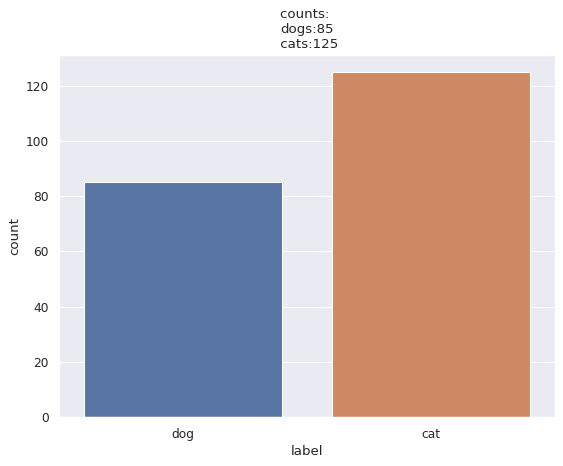

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
sns.set_theme(style="darkgrid")
sns.countplot('label',data=train_data)
plt.title('counts: \n' +'dogs:'+str(train_data.label.value_counts()[1])+
          '\n cats:'+str(train_data.label.value_counts()[0]))
plt.show()

# 3. Create test_data

In [ ]:
ID=[]
label=[]
# import required module
import os
# assign directory
directory = '../input/audio-cats-and-dogs/cats_dogs/test/'
 
# iterate over files in
# that directory

for folder in os.listdir(directory):
    for filename in os.listdir(directory+str(folder)):
        f = os.path.join(directory+str(folder), filename)
        if os.path.isfile(f):
            ID.append(f.split('/')[-1])
            label.append(f.split('/')[-2])

## In test set it should be 'dogs' instead of 'test' folder

In [ ]:
label[:10]

['test',
 'test',
 'test',
 'test',
 'test',
 'test',
 'test',
 'test',
 'test',
 'test']

## Change the labels to 'dogs'

In [ ]:
for i in range(len(label)):
    if(label[i]=='test'):
        label[i]='dogs'

label[:10]

['dogs',
 'dogs',
 'dogs',
 'dogs',
 'dogs',
 'dogs',
 'dogs',
 'dogs',
 'dogs',
 'dogs']

In [ ]:
test_data=pd.DataFrame()
test_data['ID']=ID
test_data['label']=label
test_data

,ID,label
0,dog_barking_15.wav,dogs
1,dog_barking_9.wav,dogs
2,dog_barking_66.wav,dogs
3,dog_barking_34.wav,dogs
4,dog_barking_45.wav,dogs
...,...,...
62,cat_115.wav,cats
63,cat_85.wav,cats
64,cat_14.wav,cats
65,cat_82.wav,cats


# 4. Feature extraction of audio files using MFCCs

## This function will access the audio files directly from the dataset and automatically store the features for each file in train set

## In librosa.load function if we dont write sr=None, it will upsample every audio file to 22Khz which we dont want here.

## I have used 100 Mel freq cepstrum coeff. for each audio file.

In [ ]:
def extract_features(directory):
    features=[]
    ID=[]
    for folder in os.listdir(directory):
        for filename in os.listdir(directory+str(folder)):
            f = os.path.join(directory+str(folder), filename)
            if os.path.isfile(f):
                x,sr=librosa.load(f, res_type='kaiser_fast',sr=None)
                mfccs=np.mean(librosa.feature.mfcc(x,sr=sr,n_mfcc=100).T,axis=0)
                features.append(mfccs)
                ID.append(f.split('/')[-1])
    return [ID, features]

## call on train data set

In [ ]:
ID, features_train=extract_features('../input/audio-cats-and-dogs/cats_dogs/train/')

## This step is required to check that the ID's that we obtained from extract_features function are matching with the actual ID's in train_data that we created earlier such that there's no mismatch of data rows.

In [ ]:
#checking that if they are same, there should be no zero or false value

print(np.count_nonzero(train_data.ID==ID) )

#the ablove thing should be equal to the original shape of ID's in train_data

len(train_data.ID)==np.count_nonzero(train_data.ID==ID) 


210


True

## call on test data

In [ ]:
ID,features_test=extract_features('../input/audio-cats-and-dogs/cats_dogs/test/')

len(test_data.ID)==np.count_nonzero(test_data.ID==ID)   #matched 

True

# 5. Create X_train, Y_train & X_test, Y_test

In [ ]:
X_train=np.array(features_train)
X_test=np.array(features_test)

In [ ]:
Y_train=train_data.label
Y_test=test_data.label

In [ ]:
#label encode Y_train and Y_test

le=LabelEncoder()

temp=le.fit_transform(Y_train)
Y_train=temp.reshape(-1,1)

temp=le.fit_transform(Y_test)
Y_test=temp.reshape(-1,1)

In [ ]:
print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)   

(210, 100) (67, 100)
(210, 1) (67, 1)


## perfect now lets build the classification model

# 6. Build audio classification model

## input shape will be 100 since there are 100 mfccs for each audio file

In [ ]:
model=tf.keras.Sequential()
model.add(layers.Dense(input_shape=(100,), units= 200,activation='relu'))
model.add(layers.Dense(200,activation='relu'))
model.add(layers.Dense(200,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

2021-10-25 05:04:03.326776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-25 05:04:03.421658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-25 05:04:03.422385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-25 05:04:03.423868: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 100,801
Trainable params: 100,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
hist=model.fit(X_train,Y_train,epochs=100)

2021-10-25 05:04:05.909023: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
7/7 [==============================] - 1s 3ms/step - loss: 3.0526 - accuracy: 0.7048
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.8429 - accuracy: 0.7952
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4539 - accuracy: 0.8524
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 0.3288 - accuracy: 0.8905
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1998 - accuracy: 0.9190
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1846 - accuracy: 0.9381
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1723 - accuracy: 0.9381
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1054 - accuracy: 0.9524
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1361 - accuracy: 0.9429
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.9238
Epoch 11/100
7/7 [===========

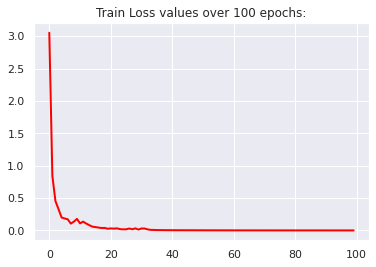

In [ ]:
plt.title('Train Loss values over 100 epochs:')
plt.plot(hist.history['loss'],color='red',linewidth=2)
plt.show()

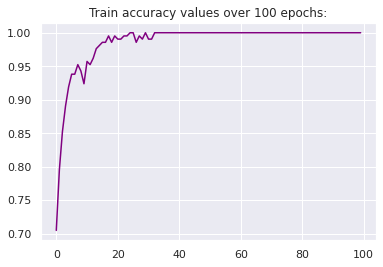

In [ ]:
plt.title('Train accuracy values over 100 epochs:')
plt.plot(hist.history['accuracy'],color='purple')
plt.show()

# 7. Testing the model with test data and metrics

In [ ]:
Y_pred=model.predict(X_test)

In [ ]:
#since we are using sigmoid activation function at the output layer
Y_pred=(Y_pred>0.5)*1

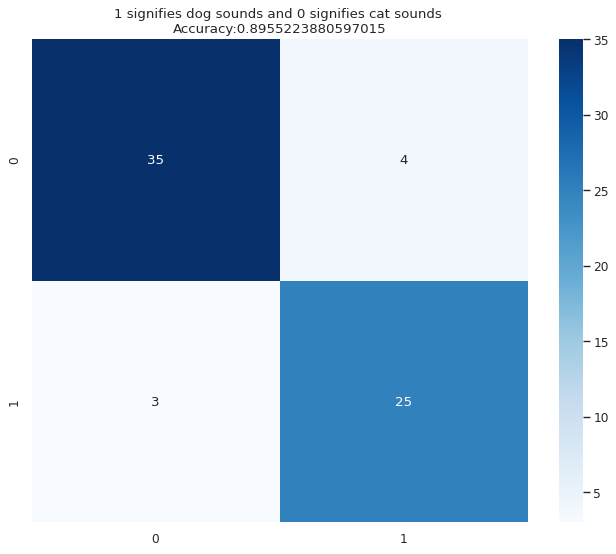

In [ ]:
plt.figure(figsize=(10,8),dpi=80)
sns.heatmap(confusion_matrix(Y_test,Y_pred),annot=True,cmap='Blues')
plt.title('1 signifies dog sounds and 0 signifies cat sounds \n'+'Accuracy:'+str(accuracy_score(Y_test,Y_pred)))
plt.show()

## Full classification report

In [ ]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        39
           1       0.86      0.89      0.88        28

    accuracy                           0.90        67
   macro avg       0.89      0.90      0.89        67
weighted avg       0.90      0.90      0.90        67



## so we have achieved around 90% test accuracy, Not bad given that the dataset is pretty small!

# Upvote if you found this useful!